Populating the interactive namespace from numpy and matplotlib


`%matplotlib` prevents importing * from pylab and numpy


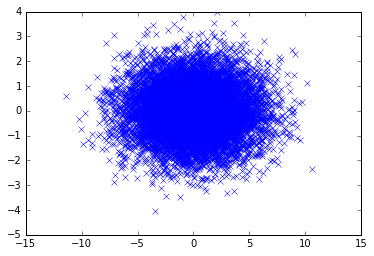

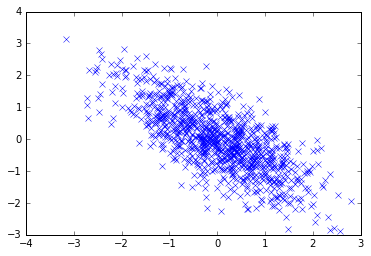

In [6]:
####Problem 7####
import matplotlib.pyplot as plt
%pylab inline

mean = [0, 0]
cov = [[9, 0], [0, 1]]
x, y = np.random.multivariate_normal(mean, cov, 10000).T
plt.plot(x, y, 'x')
plt.show()

mean = [0, 0]
cov = [[1, -0.75], [-0.75,1]]
x, y = np.random.multivariate_normal(mean, cov, 1000).T
plt.plot(x, y, 'x')
plt.show()

In [152]:
####Problem 9####
from struct import unpack
import numpy as np
import matplotlib.pylab as plt 

def loadmnist(imagefile, labelfile):

    # Open the images with gzip in read binary mode
    images = open(imagefile, 'rb')
    labels = open(labelfile, 'rb')

    # Get metadata for images
    images.read(4)  # skip the magic_number
    number_of_images = images.read(4)
    number_of_images = unpack('>I', number_of_images)[0]
    rows = images.read(4)
    rows = unpack('>I', rows)[0]
    cols = images.read(4)
    cols = unpack('>I', cols)[0]

    # Get metadata for labels
    labels.read(4)
    N = labels.read(4)
    N = unpack('>I', N)[0]

    # Get data
    x = np.zeros((N, rows*cols), dtype=np.uint8)  # Initialize numpy array
    y = np.zeros(N, dtype=np.uint8)  # Initialize numpy array
    for i in range(N):
        for j in range(rows*cols):
            tmp_pixel = images.read(1)  # Just a single byte
            tmp_pixel = unpack('>B', tmp_pixel)[0]
            x[i][j] = tmp_pixel
        tmp_label = labels.read(1)
        y[i] = unpack('>B', tmp_label)[0]

    images.close()
    labels.close()
    return (x, y)

def displaychar(image):
    plt.imshow(np.reshape(image, (28,28)), cmap=plt.cm.gray)
    plt.axis('off')
    plt.show()

In [ ]:
####Problem 7####
import matplotlib.pyplot as plt
mean = [0, 0]
cov = [[9, 0], [0, 1]]
x, y = np.random.multivariate_normal(mean, cov, 10000).T
plt.plot(x, y, 'x')
plt.show()

mean = [0, 0]
cov = [[1, -0.75], [-0.75,1]]
x, y = np.random.multivariate_normal(mean, cov, 1000).T
plt.plot(x, y, 'x')
plt.show()

In [3]:
from sklearn.cross_validation import train_test_split
####Loading the train and test data####
x,y = loadmnist ('train-images-idx3-ubyte', 'train-labels-idx1-ubyte')
x_test,y_test = loadmnist ('t10k-images-idx3-ubyte', 't10k-labels-idx1-ubyte')
####Splitting the train data into smaller train and evaluation set####
x_train, x_val, y_train, y_val = train_test_split(x,y, test_size=0.13)

In [8]:
import pandas as pd
####Data Prepration-Importing the data onto dataframes and joining the labels to them####

x_train_DF=pd.DataFrame(x_train)
y_train_DF=pd.DataFrame(y_train, columns=['digit_label'])
x_train_label_DF=x_train_DF.join(y_train_DF)

x_val_DF=pd.DataFrame(x_val)
y_val_DF=pd.DataFrame(y_val, columns=['digit_label'])
x_val_label_DF=x_val_DF.join(y_val_DF)

x_test_DF=pd.DataFrame(x_test)
y_test_DF=pd.DataFrame(y_test, columns=['digit_label'])
x_test_label_DF=x_test_DF.join(y_test_DF)

In [9]:
####Training-Calculating the mean/covariance of each class as well as the pi_j (probablity of each class)####
total_num_class = x_train_label_DF.groupby('digit_label').count()[0].sum()
pi_j = x_train_label_DF.groupby('digit_label').count()[0]/total_num_class
pi_j_log=np.log(pi_j)
x_mean={}
x_cov={}
for i in range(10):
    x_mean[i]=np.mean(x_train_label_DF.ix[x_train_label_DF['digit_label']==i].iloc[:,:784], axis=0)
    x_cov[i]=np.cov(x_train_label_DF.ix[x_train_label_DF['digit_label']==i].iloc[:,:784].T)

In [41]:
from scipy.stats import multivariate_normal
####Gaussian classifier####
def Gaussian_classifier(x_DF,x_mean,x_cov,pi_j_log,c):
    digits=range(10)
    P={}
    x_estimate_DF=pd.DataFrame()
    for digit in digits:
        x_gauss=x_DF.iloc[:,:784]
        x_estimate_DF[digit]=multivariate_normal.logpdf(x_gauss, mean=x_mean[digit], cov=x_cov[digit]+(c*eye(784)))+pi_j_log[digit]
    x_estimate_DF['estimated_digit']=x_estimate_DF.idxmax(axis=1)
    error=np.mean(x_estimate_DF['estimated_digit']!=x_DF['digit_label'])*100
    return error, x_estimate_DF

In [27]:
####Trying different values of c on valuation set####
error_val={}
C=[10,20,50,100,200,300,500,1000,1000,2000,4000,8000,10000]
for c in C:
    error_val[c]=Gaussian_classifier(x_val_label_DF,x_mean,x_cov,pi_j_log,c)

####Choosing the c which yields the minimum error on the valuation set####
c_opt=min(error_val, key=error_val.get)

the optimum value of c is: 4000


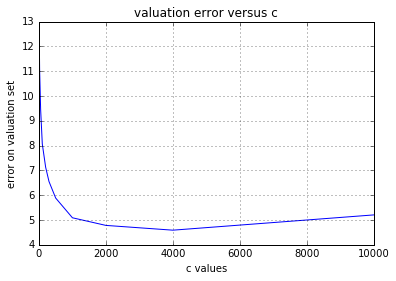

In [40]:
####Visualizing the error versus c_opt####
error_val_sorted=sorted(error_val.items())
error_val_c=[i[1] for i in error_val_sorted]
c_val=[i[0] for i in error_val_sorted]
plt.plot(c_val,error_val_c)
plt.xlabel("c values")
plt.ylabel('error on valuation set')
plt.title('valuation error versus c')
plt.grid()
print "the optimum value of c is:", c_opt

In [43]:
####calculating the error on the the train and test set####
error_test,x_estimate_test_DF=Gaussian_classifier(x_test_label_DF,x_mean,x_cov,pi_j_log,c_opt)
error_train,x_estimate_train_DF=Gaussian_classifier(x_train_label_DF,x_mean,x_cov,pi_j_log,c_opt)
print "The error on train set is:", error_train,"%\n"
print "The error on test set is:", error_test,"%\n"

The error on train set is: 4.05747126437 %

The error on test set is: 4.35 %



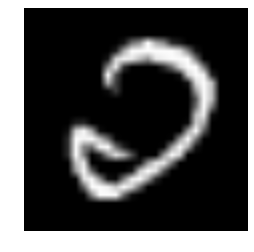

misclassified as: 0.0
posterior probabilities: 0                 -4133.881539
1                 -4404.337123
2                 -4172.422420
3                 -4215.101981
4                 -4280.101070
5                 -4214.015309
6                 -4235.835669
7                 -4298.496402
8                 -4218.195305
9                 -4247.333043
estimated_digit       0.000000
Name: 2098, dtype: float64 



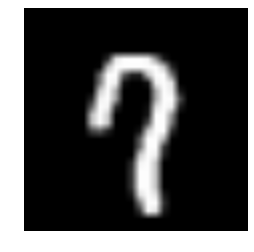

misclassified as: 9.0
posterior probabilities: 0                 -4199.851821
1                 -4215.631135
2                 -4179.308918
3                 -4173.288076
4                 -4116.583708
5                 -4185.202407
6                 -4229.786139
7                 -4096.328742
8                 -4145.514111
9                 -4088.676955
estimated_digit       9.000000
Name: 5714, dtype: float64 



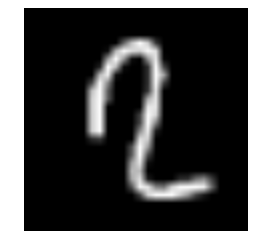

misclassified as: 8.0
posterior probabilities: 0                 -4205.753076
1                 -4215.620889
2                 -4176.618632
3                 -4187.572721
4                 -4178.171174
5                 -4191.236701
6                 -4200.508453
7                 -4218.116524
8                 -4164.963196
9                 -4192.107331
estimated_digit       8.000000
Name: 4248, dtype: float64 



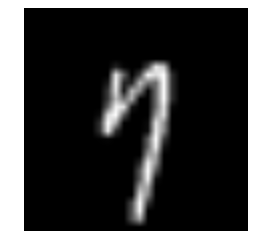

misclassified as: 9.0
posterior probabilities: 0                 -4159.738395
1                 -4132.112292
2                 -4166.567556
3                 -4151.798860
4                 -4112.644169
5                 -4153.831712
6                 -4172.138701
7                 -4104.462336
8                 -4147.360390
9                 -4098.571811
estimated_digit       9.000000
Name: 689, dtype: float64 



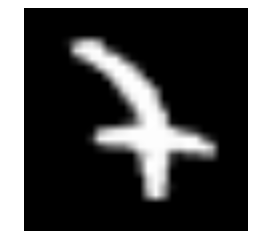

misclassified as: 2.0
posterior probabilities: 0                 -4304.141548
1                 -4267.652319
2                 -4175.139318
3                 -4187.448084
4                 -4186.233990
5                 -4220.919071
6                 -4266.537869
7                 -4187.909606
8                 -4226.278631
9                 -4245.174767
estimated_digit       2.000000
Name: 4433, dtype: float64 



In [94]:
####randomly pick 5 misclassified digits####
import random
missclassified_index=x_estimate_test_DF[x_estimate_test_DF['estimated_digit']!=x_test_label_DF['digit_label']].index
random_selection=random.sample(missclassified_index,5)
####displaying the misclassified digits, the digit they were wrongly classified as and
####and their corresponding posterior probabilities####
for rs in random_selection:
    displaychar(x_test_DF.iloc[rs])
    print "misclassified as:",x_estimate_test_DF.iloc[rs]['estimated_digit']
    print "posterior probabilities:",x_estimate_test_DF.iloc[rs],"\n"